## Import Libraries


In [2]:
import xgboost
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import *
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour, TomekLinks
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from catboost import CatBoostClassifier
from collections import defaultdict
from sklearn import tree
import matplotlib.pyplot as plt
import sklearn.metrics as metrics


## Read input csv file and remove quotes from features

In [3]:
#Loading data from csv
rm_quote = lambda x: x.replace('\'', '')


data = pd.read_csv(r"data.csv", engine='python', converters={'customer': rm_quote, 'merchant': rm_quote, 'age': rm_quote, 'gender': rm_quote, 'zipMerchant': rm_quote, 'zipcodeOri': rm_quote})

data = data.rename(columns=rm_quote)

data.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,'es_transportation',4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,'es_transportation',39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,'es_transportation',26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,'es_transportation',17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,'es_transportation',35.72,0


## check frand and non-fraud percentage

In [4]:
total = data.shape[0]
normal = data[data.fraud == 0].step.count()
fraudulent = total - normal
print("total transactions = ",total)
print("non-fraud percentage = ",round(100*normal/total,2))
print("fraud percentage = ",round(100 *fraudulent/total,2))

total transactions =  594643
non-fraud percentage =  98.79
fraud percentage =  1.21


## Split data into features and label

In [5]:
label=data.fraud
features=data.drop('fraud',axis=1)
label.head()
features.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount
0,0,C1093826151,4,M,28007,M348934600,28007,'es_transportation',4.55
1,0,C352968107,2,M,28007,M348934600,28007,'es_transportation',39.68
2,0,C2054744914,4,F,28007,M1823072687,28007,'es_transportation',26.89
3,0,C1760612790,3,M,28007,M348934600,28007,'es_transportation',17.25
4,0,C757503768,5,M,28007,M348934600,28007,'es_transportation',35.72


## Drop features with only one or all unique values

In [6]:
features =  features.drop(['step','zipcodeOri', 'zipMerchant', 'customer'], axis = 1)
features.head()

,age,gender,merchant,category,amount
0,4,M,M348934600,'es_transportation',4.55
1,2,M,M348934600,'es_transportation',39.68
2,4,F,M1823072687,'es_transportation',26.89
3,3,M,M348934600,'es_transportation',17.25
4,5,M,M348934600,'es_transportation',35.72


## Check the distribution of "amount" feature

In [7]:
data['amount'].describe()

count    594643.000000
mean         37.890135
std         111.402831
min           0.000000
25%          13.740000
50%          26.900000
75%          42.540000
max        8329.960000
Name: amount, dtype: float64

## Apply MinMaxScalar on "amount" feature as this is varying a lot

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['amount']] = scaler.fit_transform(data[['amount']])
data.head(100)
features.amount = data.amount
features.head()

,age,gender,merchant,category,amount
0,4,M,M348934600,'es_transportation',0.000546
1,2,M,M348934600,'es_transportation',0.004764
2,4,F,M1823072687,'es_transportation',0.003228
3,3,M,M348934600,'es_transportation',0.002071
4,5,M,M348934600,'es_transportation',0.004288


## Perform one hot encoding on the categorical features

In [9]:
features_final = pd.get_dummies(features)
features_final.head()

,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,0.000546,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.004764,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.003228,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.002071,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.004288,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Function for hybrid sampling

In [10]:
def hybrid_sampling(features, class_label):
    # Under sampling and over sampling
    osus = SMOTETomek(ratio=0.5, random_state=1)
    x_train_resample, y_train_resample = osus.fit_sample(features, class_label)
    return x_train_resample, y_train_resample


## Function to train the classifiers

In [11]:
def train_classifier(x_train, y_train, n_folds, classifiers):
    
    # k - fold cross validation
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(x_train)
    
    f1_scores = {}
    accuracy = {}
    conf_matrix = {}  

    fold=0
    for train_index, test_index in kf.split(x_train):
        fold += 1
        print("fold=", fold)
        X_train_fold, X_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold= y_train.iloc[train_index], y_train.iloc[test_index]

        predictions = {}
        f1_scores[fold] = {}
        accuracy[fold] = {}
        conf_matrix[fold] = {}  
        
        for model, classifier in classifiers.items():
            print("Classifier=", classifier)
            clf = eval(classifier)

            clf.fit(X_train_fold, y_train_fold)
            predictions[model] = clf.predict(X_test_fold)

            # Making the Confusion Matrix
            conf_matrix[fold][model] = confusion_matrix(y_test_fold, predictions[model])
            f1_scores[fold][model] = fbeta_score( y_test_fold, predictions[model], average='macro', beta=1)
            accuracy[fold][model] = accuracy_score( y_test_fold, predictions[model])

    return conf_matrix, f1_scores, accuracy


## Calculating average score of all crossvalidation scores of each model

In [14]:
def calculate_average_performance(data_dict):

    score = {} 
    fold_cnt = 0
    for fold, p_dict in data_dict.items():
        fold_cnt += 1
        for model, value in p_dict.items():
            if model in score:
                score[model] += value
            else:
                score[model] = value

    
    for model, value in score.items():
        score[model] = float(value) / float(fold_cnt)

    return score

## Function for Parameter Tuning

In [19]:
parameters = {'n_estimators': [5, 10 , 100],
              'min_samples_split': [2, 10, 50],
              'max_features': ["sqrt", "log2"],
              'learning_rate' : [0.5, 0.10, 0.15, 0.20],
               'max_depth' : [5, 10, 15, 20]
             }


def tune_param(classifier, features_final, label, parameters):
   
    X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    label, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
    clf = eval(classifier)    
    
    scorer = make_scorer(fbeta_score, beta=1)
    grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, n_jobs=-1)
    grid_fit = grid_obj.fit(X_train, y_train)
    best_clf = grid_fit.best_estimator_

    return best_clf

# print(tune_param('CatBoostClassifier()', features_final, label, parameters))

## prepare a dictinary with classifier and best parameters identified using parameter tuning


In [20]:
classifiers = {}
classifiers['SVM'] = "SVC(gamma='scale')"
classifiers['Decision Tree'] = "tree.DecisionTreeClassifier()"
classifiers['Random Forest'] = "RandomForestClassifier(n_jobs=-1)"
classifiers['XGBoost'] = "xgboost.XGBClassifier(n_jobs=-1)"
classifiers['CatBoost'] = "CatBoostClassifier(iterations = 1000, learning_rate = 0.10, max_depth = 5)"


## Train CLassifiers on original Features

In [21]:
# features_final, label = hybrid_sampling(features, class_label)

confusion_matrix_orig, f1_scores_orig, accuracy_orig = train_classifier(features_final, label, 3, classifiers)

print(confusion_matrix_orig)
print("F- average", calculate_average_performance(f1_scores_orig))
print("Accuracy Average", calculate_average_performance(accuracy_orig))


fold= 1
Classifier= SVC(gamma='scale')
Classifier= tree.DecisionTreeClassifier()
Classifier= RandomForestClassifier(n_jobs=-1)


c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier(iterations = 1000, learning_rate = 0.10, max_depth = 5)
0:	learn: 0.4521483	total: 186ms	remaining: 3m 5s
1:	learn: 0.2820801	total: 297ms	remaining: 2m 28s
2:	learn: 0.1911646	total: 431ms	remaining: 2m 23s
3:	learn: 0.1308610	total: 546ms	remaining: 2m 15s
4:	learn: 0.0946586	total: 685ms	remaining: 2m 16s
5:	learn: 0.0680501	total: 802ms	remaining: 2m 12s
6:	learn: 0.0379620	total: 926ms	remaining: 2m 11s
7:	learn: 0.0334863	total: 1.04s	remaining: 2m 9s
8:	learn: 0.0294732	total: 1.16s	remaining: 2m 7s
9:	learn: 0.0258517	total: 1.29s	remaining: 2m 7s
10:	learn: 0.0233762	total: 1.41s	remaining: 2m 7s
11:	learn: 0.0213919	total: 1.52s	remaining: 2m 5s
12:	learn: 0.0200156	total: 1.63s	remaining: 2m 3s
13:	learn: 0.0189255	total: 1.74s	remaining: 2m 2s
14:	learn: 0.0182082	total: 1.84s	remaining: 2m
15:	learn: 0.0173200	total: 1.95s	remaining: 2m
16:	learn: 0.0168250	total: 2.07s	remaining: 1m 59s
17:	learn:

156:	learn: 0.0103360	total: 19.1s	remaining: 1m 42s
157:	learn: 0.0103298	total: 19.2s	remaining: 1m 42s
158:	learn: 0.0103156	total: 19.3s	remaining: 1m 42s
159:	learn: 0.0103104	total: 19.5s	remaining: 1m 42s
160:	learn: 0.0103027	total: 19.6s	remaining: 1m 42s
161:	learn: 0.0102992	total: 19.7s	remaining: 1m 41s
162:	learn: 0.0102955	total: 19.8s	remaining: 1m 41s
163:	learn: 0.0102912	total: 19.9s	remaining: 1m 41s
164:	learn: 0.0102856	total: 20.1s	remaining: 1m 41s
165:	learn: 0.0102776	total: 20.2s	remaining: 1m 41s
166:	learn: 0.0102735	total: 20.3s	remaining: 1m 41s
167:	learn: 0.0102691	total: 20.4s	remaining: 1m 41s
168:	learn: 0.0102640	total: 20.6s	remaining: 1m 41s
169:	learn: 0.0102551	total: 20.7s	remaining: 1m 40s
170:	learn: 0.0102515	total: 20.8s	remaining: 1m 40s
171:	learn: 0.0102462	total: 20.9s	remaining: 1m 40s
172:	learn: 0.0102355	total: 21s	remaining: 1m 40s
173:	learn: 0.0102314	total: 21.2s	remaining: 1m 40s
174:	learn: 0.0102170	total: 21.3s	remaining: 1m

312:	learn: 0.0095388	total: 38.4s	remaining: 1m 24s
313:	learn: 0.0095301	total: 38.5s	remaining: 1m 24s
314:	learn: 0.0095282	total: 38.6s	remaining: 1m 24s
315:	learn: 0.0095230	total: 38.8s	remaining: 1m 23s
316:	learn: 0.0095188	total: 38.9s	remaining: 1m 23s
317:	learn: 0.0095152	total: 39s	remaining: 1m 23s
318:	learn: 0.0095120	total: 39.1s	remaining: 1m 23s
319:	learn: 0.0095092	total: 39.2s	remaining: 1m 23s
320:	learn: 0.0095057	total: 39.4s	remaining: 1m 23s
321:	learn: 0.0095022	total: 39.5s	remaining: 1m 23s
322:	learn: 0.0094989	total: 39.6s	remaining: 1m 23s
323:	learn: 0.0094957	total: 39.7s	remaining: 1m 22s
324:	learn: 0.0094925	total: 39.9s	remaining: 1m 22s
325:	learn: 0.0094897	total: 40s	remaining: 1m 22s
326:	learn: 0.0094876	total: 40.1s	remaining: 1m 22s
327:	learn: 0.0094856	total: 40.2s	remaining: 1m 22s
328:	learn: 0.0094824	total: 40.4s	remaining: 1m 22s
329:	learn: 0.0094805	total: 40.5s	remaining: 1m 22s
330:	learn: 0.0094783	total: 40.6s	remaining: 1m 2

468:	learn: 0.0090335	total: 58.2s	remaining: 1m 5s
469:	learn: 0.0090316	total: 58.3s	remaining: 1m 5s
470:	learn: 0.0090293	total: 58.5s	remaining: 1m 5s
471:	learn: 0.0090271	total: 58.6s	remaining: 1m 5s
472:	learn: 0.0090252	total: 58.7s	remaining: 1m 5s
473:	learn: 0.0090236	total: 58.8s	remaining: 1m 5s
474:	learn: 0.0090218	total: 58.9s	remaining: 1m 5s
475:	learn: 0.0090206	total: 59.1s	remaining: 1m 5s
476:	learn: 0.0090194	total: 59.2s	remaining: 1m 4s
477:	learn: 0.0090178	total: 59.3s	remaining: 1m 4s
478:	learn: 0.0090160	total: 59.4s	remaining: 1m 4s
479:	learn: 0.0090124	total: 59.5s	remaining: 1m 4s
480:	learn: 0.0090112	total: 59.7s	remaining: 1m 4s
481:	learn: 0.0090100	total: 59.8s	remaining: 1m 4s
482:	learn: 0.0090092	total: 59.9s	remaining: 1m 4s
483:	learn: 0.0090077	total: 1m	remaining: 1m 3s
484:	learn: 0.0090054	total: 1m	remaining: 1m 3s
485:	learn: 0.0090035	total: 1m	remaining: 1m 3s
486:	learn: 0.0090020	total: 1m	remaining: 1m 3s
487:	learn: 0.0089986	to

626:	learn: 0.0087200	total: 1m 17s	remaining: 46.2s
627:	learn: 0.0087145	total: 1m 17s	remaining: 46.1s
628:	learn: 0.0087130	total: 1m 17s	remaining: 46s
629:	learn: 0.0087112	total: 1m 18s	remaining: 45.9s
630:	learn: 0.0087096	total: 1m 18s	remaining: 45.7s
631:	learn: 0.0087072	total: 1m 18s	remaining: 45.6s
632:	learn: 0.0087063	total: 1m 18s	remaining: 45.5s
633:	learn: 0.0087027	total: 1m 18s	remaining: 45.4s
634:	learn: 0.0087015	total: 1m 18s	remaining: 45.2s
635:	learn: 0.0086992	total: 1m 18s	remaining: 45.1s
636:	learn: 0.0086972	total: 1m 18s	remaining: 45s
637:	learn: 0.0086951	total: 1m 19s	remaining: 44.9s
638:	learn: 0.0086919	total: 1m 19s	remaining: 44.7s
639:	learn: 0.0086906	total: 1m 19s	remaining: 44.6s
640:	learn: 0.0086898	total: 1m 19s	remaining: 44.5s
641:	learn: 0.0086895	total: 1m 19s	remaining: 44.3s
642:	learn: 0.0086891	total: 1m 19s	remaining: 44.2s
643:	learn: 0.0086864	total: 1m 19s	remaining: 44.1s
644:	learn: 0.0086826	total: 1m 19s	remaining: 44s

782:	learn: 0.0084465	total: 1m 36s	remaining: 26.9s
783:	learn: 0.0084453	total: 1m 37s	remaining: 26.7s
784:	learn: 0.0084434	total: 1m 37s	remaining: 26.6s
785:	learn: 0.0084408	total: 1m 37s	remaining: 26.5s
786:	learn: 0.0084386	total: 1m 37s	remaining: 26.4s
787:	learn: 0.0084371	total: 1m 37s	remaining: 26.3s
788:	learn: 0.0084366	total: 1m 37s	remaining: 26.1s
789:	learn: 0.0084350	total: 1m 37s	remaining: 26s
790:	learn: 0.0084318	total: 1m 38s	remaining: 25.9s
791:	learn: 0.0084301	total: 1m 38s	remaining: 25.8s
792:	learn: 0.0084293	total: 1m 38s	remaining: 25.7s
793:	learn: 0.0084290	total: 1m 38s	remaining: 25.6s
794:	learn: 0.0084262	total: 1m 38s	remaining: 25.4s
795:	learn: 0.0084257	total: 1m 38s	remaining: 25.3s
796:	learn: 0.0084244	total: 1m 38s	remaining: 25.2s
797:	learn: 0.0084235	total: 1m 39s	remaining: 25.1s
798:	learn: 0.0084223	total: 1m 39s	remaining: 25s
799:	learn: 0.0084219	total: 1m 39s	remaining: 24.9s
800:	learn: 0.0084208	total: 1m 39s	remaining: 24.

938:	learn: 0.0082431	total: 1m 57s	remaining: 7.62s
939:	learn: 0.0082410	total: 1m 57s	remaining: 7.49s
940:	learn: 0.0082394	total: 1m 57s	remaining: 7.37s
941:	learn: 0.0082386	total: 1m 57s	remaining: 7.24s
942:	learn: 0.0082377	total: 1m 57s	remaining: 7.12s
943:	learn: 0.0082364	total: 1m 57s	remaining: 6.99s
944:	learn: 0.0082341	total: 1m 57s	remaining: 6.87s
945:	learn: 0.0082320	total: 1m 58s	remaining: 6.74s
946:	learn: 0.0082306	total: 1m 58s	remaining: 6.62s
947:	learn: 0.0082298	total: 1m 58s	remaining: 6.49s
948:	learn: 0.0082280	total: 1m 58s	remaining: 6.37s
949:	learn: 0.0082267	total: 1m 58s	remaining: 6.24s
950:	learn: 0.0082263	total: 1m 58s	remaining: 6.12s
951:	learn: 0.0082256	total: 1m 58s	remaining: 5.99s
952:	learn: 0.0082249	total: 1m 58s	remaining: 5.87s
953:	learn: 0.0082245	total: 1m 59s	remaining: 5.74s
954:	learn: 0.0082224	total: 1m 59s	remaining: 5.62s
955:	learn: 0.0082220	total: 1m 59s	remaining: 5.49s
956:	learn: 0.0082211	total: 1m 59s	remaining:

c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier(iterations = 1000, learning_rate = 0.10, max_depth = 5)
0:	learn: 0.4578303	total: 123ms	remaining: 2m 2s
1:	learn: 0.2111285	total: 239ms	remaining: 1m 59s
2:	learn: 0.1045858	total: 369ms	remaining: 2m 2s
3:	learn: 0.0603377	total: 481ms	remaining: 1m 59s
4:	learn: 0.0406224	total: 601ms	remaining: 1m 59s
5:	learn: 0.0313132	total: 726ms	remaining: 2m
6:	learn: 0.0264044	total: 848ms	remaining: 2m
7:	learn: 0.0236933	total: 965ms	remaining: 1m 59s
8:	learn: 0.0220085	total: 1.08s	remaining: 1m 59s
9:	learn: 0.0205432	total: 1.21s	remaining: 2m
10:	learn: 0.0198293	total: 1.35s	remaining: 2m 1s
11:	learn: 0.0191042	total: 1.46s	remaining: 2m
12:	learn: 0.0184493	total: 1.58s	remaining: 2m
13:	learn: 0.0178115	total: 1.71s	remaining: 2m
14:	learn: 0.0174127	total: 1.83s	remaining: 1m 59s
15:	learn: 0.0171160	total: 1.95s	remaining: 1m 59s
16:	learn: 0.0168632	total: 2.07s	remaining: 1m 59s
17:	learn: 0.0166241	

156:	learn: 0.0116172	total: 19.2s	remaining: 1m 42s
157:	learn: 0.0116111	total: 19.3s	remaining: 1m 42s
158:	learn: 0.0116054	total: 19.4s	remaining: 1m 42s
159:	learn: 0.0116027	total: 19.5s	remaining: 1m 42s
160:	learn: 0.0116000	total: 19.7s	remaining: 1m 42s
161:	learn: 0.0115917	total: 19.8s	remaining: 1m 42s
162:	learn: 0.0115866	total: 19.9s	remaining: 1m 42s
163:	learn: 0.0115820	total: 20s	remaining: 1m 42s
164:	learn: 0.0115781	total: 20.1s	remaining: 1m 41s
165:	learn: 0.0115766	total: 20.3s	remaining: 1m 41s
166:	learn: 0.0115718	total: 20.4s	remaining: 1m 41s
167:	learn: 0.0115645	total: 20.5s	remaining: 1m 41s
168:	learn: 0.0115589	total: 20.6s	remaining: 1m 41s
169:	learn: 0.0115560	total: 20.7s	remaining: 1m 41s
170:	learn: 0.0115480	total: 20.9s	remaining: 1m 41s
171:	learn: 0.0115437	total: 21s	remaining: 1m 41s
172:	learn: 0.0115388	total: 21.1s	remaining: 1m 40s
173:	learn: 0.0115358	total: 21.2s	remaining: 1m 40s
174:	learn: 0.0115312	total: 21.4s	remaining: 1m 4

312:	learn: 0.0110201	total: 38.4s	remaining: 1m 24s
313:	learn: 0.0110181	total: 38.5s	remaining: 1m 24s
314:	learn: 0.0110141	total: 38.6s	remaining: 1m 23s
315:	learn: 0.0110125	total: 38.7s	remaining: 1m 23s
316:	learn: 0.0110113	total: 38.8s	remaining: 1m 23s
317:	learn: 0.0110102	total: 39s	remaining: 1m 23s
318:	learn: 0.0110090	total: 39.1s	remaining: 1m 23s
319:	learn: 0.0110078	total: 39.2s	remaining: 1m 23s
320:	learn: 0.0110058	total: 39.3s	remaining: 1m 23s
321:	learn: 0.0110031	total: 39.5s	remaining: 1m 23s
322:	learn: 0.0110016	total: 39.6s	remaining: 1m 22s
323:	learn: 0.0110004	total: 39.7s	remaining: 1m 22s
324:	learn: 0.0109989	total: 39.8s	remaining: 1m 22s
325:	learn: 0.0109962	total: 40s	remaining: 1m 22s
326:	learn: 0.0109925	total: 40.1s	remaining: 1m 22s
327:	learn: 0.0109898	total: 40.2s	remaining: 1m 22s
328:	learn: 0.0109884	total: 40.3s	remaining: 1m 22s
329:	learn: 0.0109875	total: 40.4s	remaining: 1m 22s
330:	learn: 0.0109863	total: 40.6s	remaining: 1m 2

468:	learn: 0.0106847	total: 57.9s	remaining: 1m 5s
469:	learn: 0.0106843	total: 58s	remaining: 1m 5s
470:	learn: 0.0106833	total: 58.1s	remaining: 1m 5s
471:	learn: 0.0106804	total: 58.2s	remaining: 1m 5s
472:	learn: 0.0106792	total: 58.4s	remaining: 1m 5s
473:	learn: 0.0106750	total: 58.5s	remaining: 1m 4s
474:	learn: 0.0106743	total: 58.6s	remaining: 1m 4s
475:	learn: 0.0106719	total: 58.7s	remaining: 1m 4s
476:	learn: 0.0106697	total: 58.9s	remaining: 1m 4s
477:	learn: 0.0106690	total: 59s	remaining: 1m 4s
478:	learn: 0.0106679	total: 59.1s	remaining: 1m 4s
479:	learn: 0.0106657	total: 59.2s	remaining: 1m 4s
480:	learn: 0.0106639	total: 59.3s	remaining: 1m 4s
481:	learn: 0.0106612	total: 59.5s	remaining: 1m 3s
482:	learn: 0.0106592	total: 59.6s	remaining: 1m 3s
483:	learn: 0.0106577	total: 59.7s	remaining: 1m 3s
484:	learn: 0.0106531	total: 59.8s	remaining: 1m 3s
485:	learn: 0.0106521	total: 59.9s	remaining: 1m 3s
486:	learn: 0.0106500	total: 1m	remaining: 1m 3s
487:	learn: 0.01064

626:	learn: 0.0104127	total: 1m 17s	remaining: 46s
627:	learn: 0.0104120	total: 1m 17s	remaining: 45.8s
628:	learn: 0.0104109	total: 1m 17s	remaining: 45.7s
629:	learn: 0.0104091	total: 1m 17s	remaining: 45.6s
630:	learn: 0.0104079	total: 1m 17s	remaining: 45.5s
631:	learn: 0.0104064	total: 1m 17s	remaining: 45.3s
632:	learn: 0.0104053	total: 1m 18s	remaining: 45.2s
633:	learn: 0.0104037	total: 1m 18s	remaining: 45.1s
634:	learn: 0.0104023	total: 1m 18s	remaining: 45s
635:	learn: 0.0104005	total: 1m 18s	remaining: 44.8s
636:	learn: 0.0103999	total: 1m 18s	remaining: 44.7s
637:	learn: 0.0103957	total: 1m 18s	remaining: 44.6s
638:	learn: 0.0103943	total: 1m 18s	remaining: 44.5s
639:	learn: 0.0103919	total: 1m 18s	remaining: 44.4s
640:	learn: 0.0103909	total: 1m 18s	remaining: 44.2s
641:	learn: 0.0103902	total: 1m 19s	remaining: 44.1s
642:	learn: 0.0103889	total: 1m 19s	remaining: 44s
643:	learn: 0.0103883	total: 1m 19s	remaining: 43.9s
644:	learn: 0.0103878	total: 1m 19s	remaining: 43.7s

782:	learn: 0.0101949	total: 1m 36s	remaining: 26.7s
783:	learn: 0.0101939	total: 1m 36s	remaining: 26.6s
784:	learn: 0.0101938	total: 1m 36s	remaining: 26.5s
785:	learn: 0.0101927	total: 1m 36s	remaining: 26.4s
786:	learn: 0.0101908	total: 1m 37s	remaining: 26.3s
787:	learn: 0.0101893	total: 1m 37s	remaining: 26.1s
788:	learn: 0.0101890	total: 1m 37s	remaining: 26s
789:	learn: 0.0101858	total: 1m 37s	remaining: 25.9s
790:	learn: 0.0101840	total: 1m 37s	remaining: 25.8s
791:	learn: 0.0101820	total: 1m 37s	remaining: 25.6s
792:	learn: 0.0101812	total: 1m 37s	remaining: 25.5s
793:	learn: 0.0101798	total: 1m 37s	remaining: 25.4s
794:	learn: 0.0101791	total: 1m 37s	remaining: 25.3s
795:	learn: 0.0101781	total: 1m 38s	remaining: 25.1s
796:	learn: 0.0101768	total: 1m 38s	remaining: 25s
797:	learn: 0.0101752	total: 1m 38s	remaining: 24.9s
798:	learn: 0.0101746	total: 1m 38s	remaining: 24.8s
799:	learn: 0.0101717	total: 1m 38s	remaining: 24.6s
800:	learn: 0.0101709	total: 1m 38s	remaining: 24.

938:	learn: 0.0100178	total: 1m 55s	remaining: 7.51s
939:	learn: 0.0100172	total: 1m 55s	remaining: 7.39s
940:	learn: 0.0100170	total: 1m 55s	remaining: 7.27s
941:	learn: 0.0100157	total: 1m 56s	remaining: 7.14s
942:	learn: 0.0100156	total: 1m 56s	remaining: 7.02s
943:	learn: 0.0100154	total: 1m 56s	remaining: 6.89s
944:	learn: 0.0100142	total: 1m 56s	remaining: 6.77s
945:	learn: 0.0100135	total: 1m 56s	remaining: 6.65s
946:	learn: 0.0100132	total: 1m 56s	remaining: 6.53s
947:	learn: 0.0100130	total: 1m 56s	remaining: 6.4s
948:	learn: 0.0100118	total: 1m 56s	remaining: 6.28s
949:	learn: 0.0100106	total: 1m 56s	remaining: 6.16s
950:	learn: 0.0100097	total: 1m 57s	remaining: 6.03s
951:	learn: 0.0100087	total: 1m 57s	remaining: 5.91s
952:	learn: 0.0100076	total: 1m 57s	remaining: 5.79s
953:	learn: 0.0100071	total: 1m 57s	remaining: 5.66s
954:	learn: 0.0100064	total: 1m 57s	remaining: 5.54s
955:	learn: 0.0100059	total: 1m 57s	remaining: 5.42s
956:	learn: 0.0100054	total: 1m 57s	remaining: 

c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier(iterations = 1000, learning_rate = 0.10, max_depth = 5)
0:	learn: 0.4467602	total: 123ms	remaining: 2m 2s
1:	learn: 0.2832739	total: 242ms	remaining: 2m
2:	learn: 0.1390251	total: 365ms	remaining: 2m 1s
3:	learn: 0.0776515	total: 477ms	remaining: 1m 58s
4:	learn: 0.0491646	total: 598ms	remaining: 1m 58s
5:	learn: 0.0362809	total: 728ms	remaining: 2m
6:	learn: 0.0294545	total: 861ms	remaining: 2m 2s
7:	learn: 0.0258991	total: 974ms	remaining: 2m
8:	learn: 0.0235231	total: 1.09s	remaining: 2m
9:	learn: 0.0219387	total: 1.21s	remaining: 1m 59s
10:	learn: 0.0201508	total: 1.33s	remaining: 1m 59s
11:	learn: 0.0194789	total: 1.44s	remaining: 1m 58s
12:	learn: 0.0187707	total: 1.56s	remaining: 1m 58s
13:	learn: 0.0183433	total: 1.67s	remaining: 1m 57s
14:	learn: 0.0179553	total: 1.79s	remaining: 1m 57s
15:	learn: 0.0177073	total: 1.9s	remaining: 1m 56s
16:	learn: 0.0173508	total: 2.02s	remaining: 1m 56s
17:	learn: 0.0

156:	learn: 0.0126454	total: 19.1s	remaining: 1m 42s
157:	learn: 0.0126402	total: 19.2s	remaining: 1m 42s
158:	learn: 0.0126350	total: 19.3s	remaining: 1m 42s
159:	learn: 0.0126280	total: 19.5s	remaining: 1m 42s
160:	learn: 0.0126197	total: 19.6s	remaining: 1m 42s
161:	learn: 0.0126133	total: 19.8s	remaining: 1m 42s
162:	learn: 0.0126071	total: 19.9s	remaining: 1m 42s
163:	learn: 0.0126001	total: 20.1s	remaining: 1m 42s
164:	learn: 0.0125933	total: 20.3s	remaining: 1m 42s
165:	learn: 0.0125887	total: 20.4s	remaining: 1m 42s
166:	learn: 0.0125816	total: 20.6s	remaining: 1m 42s
167:	learn: 0.0125749	total: 20.8s	remaining: 1m 42s
168:	learn: 0.0125730	total: 20.9s	remaining: 1m 42s
169:	learn: 0.0125687	total: 21.1s	remaining: 1m 43s
170:	learn: 0.0125624	total: 21.3s	remaining: 1m 43s
171:	learn: 0.0125543	total: 21.4s	remaining: 1m 43s
172:	learn: 0.0125482	total: 21.6s	remaining: 1m 43s
173:	learn: 0.0125398	total: 21.8s	remaining: 1m 43s
174:	learn: 0.0125357	total: 21.9s	remaining: 

313:	learn: 0.0119235	total: 42.5s	remaining: 1m 32s
314:	learn: 0.0119182	total: 42.7s	remaining: 1m 32s
315:	learn: 0.0119171	total: 42.8s	remaining: 1m 32s
316:	learn: 0.0119149	total: 42.9s	remaining: 1m 32s
317:	learn: 0.0119128	total: 43.1s	remaining: 1m 32s
318:	learn: 0.0119094	total: 43.2s	remaining: 1m 32s
319:	learn: 0.0119072	total: 43.4s	remaining: 1m 32s
320:	learn: 0.0119026	total: 43.5s	remaining: 1m 32s
321:	learn: 0.0118992	total: 43.7s	remaining: 1m 31s
322:	learn: 0.0118978	total: 43.8s	remaining: 1m 31s
323:	learn: 0.0118954	total: 44s	remaining: 1m 31s
324:	learn: 0.0118921	total: 44.1s	remaining: 1m 31s
325:	learn: 0.0118877	total: 44.2s	remaining: 1m 31s
326:	learn: 0.0118847	total: 44.4s	remaining: 1m 31s
327:	learn: 0.0118811	total: 44.5s	remaining: 1m 31s
328:	learn: 0.0118792	total: 44.7s	remaining: 1m 31s
329:	learn: 0.0118782	total: 44.8s	remaining: 1m 31s
330:	learn: 0.0118751	total: 45s	remaining: 1m 30s
331:	learn: 0.0118728	total: 45.1s	remaining: 1m 3

469:	learn: 0.0115292	total: 1m 5s	remaining: 1m 13s
470:	learn: 0.0115280	total: 1m 5s	remaining: 1m 13s
471:	learn: 0.0115270	total: 1m 5s	remaining: 1m 13s
472:	learn: 0.0115260	total: 1m 5s	remaining: 1m 13s
473:	learn: 0.0115226	total: 1m 5s	remaining: 1m 13s
474:	learn: 0.0115211	total: 1m 5s	remaining: 1m 12s
475:	learn: 0.0115203	total: 1m 6s	remaining: 1m 12s
476:	learn: 0.0115168	total: 1m 6s	remaining: 1m 12s
477:	learn: 0.0115135	total: 1m 6s	remaining: 1m 12s
478:	learn: 0.0115124	total: 1m 6s	remaining: 1m 12s
479:	learn: 0.0115114	total: 1m 6s	remaining: 1m 12s
480:	learn: 0.0115102	total: 1m 6s	remaining: 1m 12s
481:	learn: 0.0115075	total: 1m 7s	remaining: 1m 12s
482:	learn: 0.0115066	total: 1m 7s	remaining: 1m 11s
483:	learn: 0.0115059	total: 1m 7s	remaining: 1m 11s
484:	learn: 0.0115048	total: 1m 7s	remaining: 1m 11s
485:	learn: 0.0115025	total: 1m 7s	remaining: 1m 11s
486:	learn: 0.0115008	total: 1m 7s	remaining: 1m 11s
487:	learn: 0.0114999	total: 1m 7s	remaining: 

625:	learn: 0.0112637	total: 1m 28s	remaining: 52.6s
626:	learn: 0.0112624	total: 1m 28s	remaining: 52.5s
627:	learn: 0.0112606	total: 1m 28s	remaining: 52.3s
628:	learn: 0.0112575	total: 1m 28s	remaining: 52.2s
629:	learn: 0.0112563	total: 1m 28s	remaining: 52.1s
630:	learn: 0.0112534	total: 1m 28s	remaining: 51.9s
631:	learn: 0.0112520	total: 1m 28s	remaining: 51.8s
632:	learn: 0.0112516	total: 1m 29s	remaining: 51.6s
633:	learn: 0.0112504	total: 1m 29s	remaining: 51.5s
634:	learn: 0.0112471	total: 1m 29s	remaining: 51.4s
635:	learn: 0.0112445	total: 1m 29s	remaining: 51.2s
636:	learn: 0.0112422	total: 1m 29s	remaining: 51.1s
637:	learn: 0.0112407	total: 1m 29s	remaining: 51s
638:	learn: 0.0112395	total: 1m 29s	remaining: 50.8s
639:	learn: 0.0112385	total: 1m 30s	remaining: 50.7s
640:	learn: 0.0112374	total: 1m 30s	remaining: 50.5s
641:	learn: 0.0112353	total: 1m 30s	remaining: 50.4s
642:	learn: 0.0112332	total: 1m 30s	remaining: 50.3s
643:	learn: 0.0112319	total: 1m 30s	remaining: 5

781:	learn: 0.0110434	total: 1m 50s	remaining: 30.9s
782:	learn: 0.0110423	total: 1m 50s	remaining: 30.8s
783:	learn: 0.0110420	total: 1m 51s	remaining: 30.6s
784:	learn: 0.0110408	total: 1m 51s	remaining: 30.5s
785:	learn: 0.0110382	total: 1m 51s	remaining: 30.3s
786:	learn: 0.0110371	total: 1m 51s	remaining: 30.2s
787:	learn: 0.0110364	total: 1m 51s	remaining: 30.1s
788:	learn: 0.0110342	total: 1m 51s	remaining: 29.9s
789:	learn: 0.0110339	total: 1m 51s	remaining: 29.8s
790:	learn: 0.0110333	total: 1m 52s	remaining: 29.6s
791:	learn: 0.0110321	total: 1m 52s	remaining: 29.5s
792:	learn: 0.0110313	total: 1m 52s	remaining: 29.3s
793:	learn: 0.0110304	total: 1m 52s	remaining: 29.2s
794:	learn: 0.0110298	total: 1m 52s	remaining: 29.1s
795:	learn: 0.0110294	total: 1m 52s	remaining: 28.9s
796:	learn: 0.0110291	total: 1m 53s	remaining: 28.8s
797:	learn: 0.0110285	total: 1m 53s	remaining: 28.6s
798:	learn: 0.0110276	total: 1m 53s	remaining: 28.5s
799:	learn: 0.0110263	total: 1m 53s	remaining:

938:	learn: 0.0108497	total: 2m 13s	remaining: 8.7s
939:	learn: 0.0108470	total: 2m 14s	remaining: 8.55s
940:	learn: 0.0108458	total: 2m 14s	remaining: 8.41s
941:	learn: 0.0108455	total: 2m 14s	remaining: 8.27s
942:	learn: 0.0108439	total: 2m 14s	remaining: 8.13s
943:	learn: 0.0108415	total: 2m 14s	remaining: 7.98s
944:	learn: 0.0108413	total: 2m 14s	remaining: 7.84s
945:	learn: 0.0108407	total: 2m 14s	remaining: 7.7s
946:	learn: 0.0108401	total: 2m 15s	remaining: 7.56s
947:	learn: 0.0108394	total: 2m 15s	remaining: 7.41s
948:	learn: 0.0108376	total: 2m 15s	remaining: 7.27s
949:	learn: 0.0108374	total: 2m 15s	remaining: 7.13s
950:	learn: 0.0108360	total: 2m 15s	remaining: 6.99s
951:	learn: 0.0108335	total: 2m 15s	remaining: 6.84s
952:	learn: 0.0108329	total: 2m 15s	remaining: 6.7s
953:	learn: 0.0108313	total: 2m 16s	remaining: 6.56s
954:	learn: 0.0108302	total: 2m 16s	remaining: 6.42s
955:	learn: 0.0108298	total: 2m 16s	remaining: 6.27s
956:	learn: 0.0108296	total: 2m 16s	remaining: 6.

## Read Graph Features

In [22]:
df_features_cust = pd.read_csv(r"customer_features.csv")
df_features_cust.head()

df_features_mrc = pd.read_csv(r"merchant_features.csv")
df_features_mrc.head()


,merchant,mer_degree,mer_pagerank,mer_community
0,M1053599405,2829,32.429804,4
1,M117188757,20,0.347098,24
2,M1198415165,1010,10.574918,20
3,M1294758098,146,1.433058,41
4,M1313686961,483,5.451986,34


## Merge features with original dataframe

In [23]:
df_merged = pd.merge(data, df_features_cust, on=['customer'], how='left')

df_merged = pd.merge(df_merged, df_features_mrc, on=['merchant'], how='left')

df_merged =  df_merged.drop(['step','zipcodeOri', 'zipMerchant', 'customer'], axis = 1)

df_merged.head()



,age,gender,merchant,category,amount,fraud,cust_degree,cust_pagerank,cust_community,mer_degree,mer_pagerank,mer_community
0,4,M,M348934600,'es_transportation',0.000546,0,7,0.15,44,3929,46.528797,0
1,2,M,M348934600,'es_transportation',0.004764,0,12,0.15,42,3929,46.528797,0
2,4,F,M1823072687,'es_transportation',0.003228,0,14,0.15,42,3573,41.379700,1
3,3,M,M348934600,'es_transportation',0.002071,0,11,0.15,42,3929,46.528797,0
4,5,M,M348934600,'es_transportation',0.004288,0,14,0.15,40,3929,46.528797,0


## Separate features and labels

In [24]:
target=df_merged.fraud
features=df_merged.drop('fraud',axis=1)

features_final = pd.get_dummies(features)


target.head()
features_final.head()


,amount,cust_degree,cust_pagerank,cust_community,mer_degree,mer_pagerank,mer_community,age_0,age_1,age_2,...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,0.000546,7,0.15,44,3929,46.528797,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.004764,12,0.15,42,3929,46.528797,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.003228,14,0.15,42,3573,41.379700,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.002071,11,0.15,42,3929,46.528797,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.004288,14,0.15,40,3929,46.528797,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Train Classifiers again with new features

In [ ]:
confusion_matrix, f1_scores, accuracy = train_classifier(features_final, target, 3, classifiers)

fold= 1
Classifier= SVC(gamma='scale')
Classifier= tree.DecisionTreeClassifier()
Classifier= RandomForestClassifier(n_jobs=-1)


c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier(iterations = 1000, learning_rate = 0.10, max_depth = 5)
0:	learn: 0.3901517	total: 121ms	remaining: 2m
1:	learn: 0.2547857	total: 235ms	remaining: 1m 57s
2:	learn: 0.1467176	total: 375ms	remaining: 2m 4s
3:	learn: 0.0909645	total: 494ms	remaining: 2m 2s
4:	learn: 0.0611705	total: 625ms	remaining: 2m 4s
5:	learn: 0.0432569	total: 744ms	remaining: 2m 3s
6:	learn: 0.0336831	total: 869ms	remaining: 2m 3s
7:	learn: 0.0292232	total: 985ms	remaining: 2m 2s
8:	learn: 0.0255288	total: 1.11s	remaining: 2m 1s
9:	learn: 0.0220776	total: 1.22s	remaining: 2m 1s
10:	learn: 0.0201905	total: 1.35s	remaining: 2m 1s
11:	learn: 0.0176798	total: 1.46s	remaining: 2m
12:	learn: 0.0169987	total: 1.59s	remaining: 2m
13:	learn: 0.0160301	total: 1.71s	remaining: 2m
14:	learn: 0.0148309	total: 1.84s	remaining: 2m
15:	learn: 0.0143926	total: 1.96s	remaining: 2m
16:	learn: 0.0138014	total: 2.1s	remaining: 2m 1s
17:	learn: 0.0135185	total: 2

158:	learn: 0.0081555	total: 21s	remaining: 1m 51s
159:	learn: 0.0081500	total: 21.1s	remaining: 1m 50s
160:	learn: 0.0081452	total: 21.2s	remaining: 1m 50s
161:	learn: 0.0081412	total: 21.4s	remaining: 1m 50s
162:	learn: 0.0081367	total: 21.5s	remaining: 1m 50s
163:	learn: 0.0081320	total: 21.6s	remaining: 1m 50s
164:	learn: 0.0081278	total: 21.7s	remaining: 1m 50s
165:	learn: 0.0081235	total: 21.9s	remaining: 1m 49s
166:	learn: 0.0081127	total: 22s	remaining: 1m 49s
167:	learn: 0.0081063	total: 22.1s	remaining: 1m 49s
168:	learn: 0.0081026	total: 22.2s	remaining: 1m 49s
169:	learn: 0.0080975	total: 22.4s	remaining: 1m 49s
170:	learn: 0.0080921	total: 22.5s	remaining: 1m 48s
171:	learn: 0.0080868	total: 22.6s	remaining: 1m 48s
172:	learn: 0.0080828	total: 22.7s	remaining: 1m 48s
173:	learn: 0.0080784	total: 22.8s	remaining: 1m 48s
174:	learn: 0.0080752	total: 23s	remaining: 1m 48s
175:	learn: 0.0080639	total: 23.1s	remaining: 1m 48s
176:	learn: 0.0080573	total: 23.2s	remaining: 1m 47s

314:	learn: 0.0073940	total: 40.6s	remaining: 1m 28s
315:	learn: 0.0073904	total: 40.7s	remaining: 1m 28s
316:	learn: 0.0073885	total: 40.9s	remaining: 1m 28s
317:	learn: 0.0073851	total: 41s	remaining: 1m 27s
318:	learn: 0.0073822	total: 41.1s	remaining: 1m 27s
319:	learn: 0.0073787	total: 41.3s	remaining: 1m 27s
320:	learn: 0.0073760	total: 41.4s	remaining: 1m 27s
321:	learn: 0.0073744	total: 41.5s	remaining: 1m 27s
322:	learn: 0.0073714	total: 41.7s	remaining: 1m 27s
323:	learn: 0.0073705	total: 41.8s	remaining: 1m 27s
324:	learn: 0.0073679	total: 41.9s	remaining: 1m 27s
325:	learn: 0.0073637	total: 42.1s	remaining: 1m 26s
326:	learn: 0.0073627	total: 42.2s	remaining: 1m 26s
327:	learn: 0.0073605	total: 42.3s	remaining: 1m 26s
328:	learn: 0.0073587	total: 42.5s	remaining: 1m 26s
329:	learn: 0.0073573	total: 42.6s	remaining: 1m 26s
330:	learn: 0.0073184	total: 42.7s	remaining: 1m 26s
331:	learn: 0.0073158	total: 42.9s	remaining: 1m 26s
332:	learn: 0.0073090	total: 43s	remaining: 1m 2

470:	learn: 0.0068821	total: 1m	remaining: 1m 8s
471:	learn: 0.0068796	total: 1m 1s	remaining: 1m 8s
472:	learn: 0.0068743	total: 1m 1s	remaining: 1m 8s
473:	learn: 0.0068716	total: 1m 1s	remaining: 1m 8s
474:	learn: 0.0068706	total: 1m 1s	remaining: 1m 7s
475:	learn: 0.0068696	total: 1m 1s	remaining: 1m 7s
476:	learn: 0.0068666	total: 1m 1s	remaining: 1m 7s
477:	learn: 0.0068646	total: 1m 1s	remaining: 1m 7s
478:	learn: 0.0068630	total: 1m 2s	remaining: 1m 7s
479:	learn: 0.0068613	total: 1m 2s	remaining: 1m 7s
480:	learn: 0.0068600	total: 1m 2s	remaining: 1m 7s
481:	learn: 0.0068582	total: 1m 2s	remaining: 1m 7s
482:	learn: 0.0068555	total: 1m 2s	remaining: 1m 6s
483:	learn: 0.0068543	total: 1m 2s	remaining: 1m 6s
484:	learn: 0.0068518	total: 1m 2s	remaining: 1m 6s
485:	learn: 0.0068498	total: 1m 2s	remaining: 1m 6s
486:	learn: 0.0068482	total: 1m 3s	remaining: 1m 6s
487:	learn: 0.0068454	total: 1m 3s	remaining: 1m 6s
488:	learn: 0.0068443	total: 1m 3s	remaining: 1m 6s
489:	learn: 0.0

628:	learn: 0.0064956	total: 1m 21s	remaining: 47.9s
629:	learn: 0.0064942	total: 1m 21s	remaining: 47.8s
630:	learn: 0.0064920	total: 1m 21s	remaining: 47.7s
631:	learn: 0.0064905	total: 1m 21s	remaining: 47.5s
632:	learn: 0.0064884	total: 1m 21s	remaining: 47.4s
633:	learn: 0.0064857	total: 1m 21s	remaining: 47.3s
634:	learn: 0.0064823	total: 1m 22s	remaining: 47.2s
635:	learn: 0.0064785	total: 1m 22s	remaining: 47s
636:	learn: 0.0064754	total: 1m 22s	remaining: 46.9s
637:	learn: 0.0064733	total: 1m 22s	remaining: 46.8s
638:	learn: 0.0064682	total: 1m 22s	remaining: 46.6s
639:	learn: 0.0064656	total: 1m 22s	remaining: 46.5s
640:	learn: 0.0064631	total: 1m 22s	remaining: 46.4s
641:	learn: 0.0064612	total: 1m 22s	remaining: 46.3s
642:	learn: 0.0064580	total: 1m 23s	remaining: 46.1s
643:	learn: 0.0064558	total: 1m 23s	remaining: 46s
644:	learn: 0.0064549	total: 1m 23s	remaining: 45.9s
645:	learn: 0.0064534	total: 1m 23s	remaining: 45.7s
646:	learn: 0.0064503	total: 1m 23s	remaining: 45.

784:	learn: 0.0061484	total: 1m 40s	remaining: 27.6s
785:	learn: 0.0061360	total: 1m 40s	remaining: 27.5s
786:	learn: 0.0061354	total: 1m 41s	remaining: 27.3s
787:	learn: 0.0061338	total: 1m 41s	remaining: 27.2s
788:	learn: 0.0061319	total: 1m 41s	remaining: 27.1s
789:	learn: 0.0061302	total: 1m 41s	remaining: 26.9s
790:	learn: 0.0061272	total: 1m 41s	remaining: 26.8s
791:	learn: 0.0061254	total: 1m 41s	remaining: 26.7s
792:	learn: 0.0061232	total: 1m 41s	remaining: 26.6s
793:	learn: 0.0061220	total: 1m 41s	remaining: 26.4s
794:	learn: 0.0061183	total: 1m 41s	remaining: 26.3s
795:	learn: 0.0061153	total: 1m 42s	remaining: 26.2s
796:	learn: 0.0061135	total: 1m 42s	remaining: 26s
797:	learn: 0.0061122	total: 1m 42s	remaining: 25.9s
798:	learn: 0.0061107	total: 1m 42s	remaining: 25.8s
799:	learn: 0.0061093	total: 1m 42s	remaining: 25.6s
800:	learn: 0.0061065	total: 1m 42s	remaining: 25.5s
801:	learn: 0.0061054	total: 1m 42s	remaining: 25.4s
802:	learn: 0.0061033	total: 1m 42s	remaining: 2

940:	learn: 0.0058417	total: 1m 59s	remaining: 7.52s
941:	learn: 0.0058406	total: 2m	remaining: 7.39s
942:	learn: 0.0058391	total: 2m	remaining: 7.26s
943:	learn: 0.0058362	total: 2m	remaining: 7.13s
944:	learn: 0.0058326	total: 2m	remaining: 7.01s
945:	learn: 0.0058310	total: 2m	remaining: 6.88s
946:	learn: 0.0058288	total: 2m	remaining: 6.75s
947:	learn: 0.0058262	total: 2m	remaining: 6.62s
948:	learn: 0.0058255	total: 2m	remaining: 6.5s
949:	learn: 0.0058244	total: 2m 1s	remaining: 6.37s
950:	learn: 0.0058232	total: 2m 1s	remaining: 6.24s
951:	learn: 0.0058224	total: 2m 1s	remaining: 6.11s
952:	learn: 0.0058203	total: 2m 1s	remaining: 5.99s
953:	learn: 0.0058178	total: 2m 1s	remaining: 5.86s
954:	learn: 0.0058151	total: 2m 1s	remaining: 5.73s
955:	learn: 0.0058141	total: 2m 1s	remaining: 5.6s
956:	learn: 0.0058117	total: 2m 1s	remaining: 5.47s
957:	learn: 0.0058097	total: 2m 1s	remaining: 5.35s
958:	learn: 0.0058086	total: 2m 2s	remaining: 5.22s
959:	learn: 0.0058063	total: 2m 2s	re

## Print Results with and without using graph features

In [47]:
print("confusion matrix \n", confusion_matrix)

avg_f1_features = calculate_average_performance(f1_scores)
avg_accuracy_features = calculate_average_performance(accuracy)

print("F- average", calculate_average_performance(f1_scores))
print("Accuracy Average", calculate_average_performance(accuracy))

avg_f1_orig = calculate_average_performance(f1_scores_orig)
avg_accuracy_orig = calculate_average_performance(accuracy_orig)


confusion matrix {1: {'tree.DecisionTreeClassifier()': array([[194440,   1043],
       [   456,   2276]], dtype=int64), 'RandomForestClassifier(n_jobs=-1)': array([[194880,    603],
       [   522,   2210]], dtype=int64), 'xgboost.XGBClassifier(n_jobs=-1)': array([[195133,    350],
       [   552,   2180]], dtype=int64), 'CatBoostClassifier()': array([[194973,    510],
       [   462,   2270]], dtype=int64)}, 2: {'tree.DecisionTreeClassifier()': array([[195434,    472],
       [   480,   1828]], dtype=int64), 'RandomForestClassifier(n_jobs=-1)': array([[195678,    228],
       [   496,   1812]], dtype=int64), 'xgboost.XGBClassifier(n_jobs=-1)': array([[195724,    182],
       [   527,   1781]], dtype=int64), 'CatBoostClassifier()': array([[195698,    208],
       [   475,   1833]], dtype=int64)}, 3: {'tree.DecisionTreeClassifier()': array([[195760,    294],
       [   547,   1613]], dtype=int64), 'RandomForestClassifier(n_jobs=-1)': array([[195922,    132],
       [   557,   1603]], dt

## Plot the accuracy comparison graphs

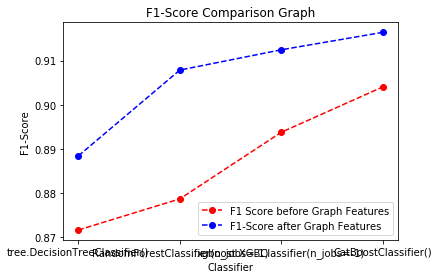

In [66]:
x1 = list(avg_f1_orig.keys())
y1 = list(avg_f1_orig.values())
plt.plot(x1, y1, 'ro', linestyle='dashed')

x2 = list(avg_f1_features.keys())
y2 = list(avg_f1_features.values())
plt.plot(x2, y2, 'bo', linestyle='dashed')

plt.savefig("out_accuracy.png")
plt.legend(['F1 Score before Graph Features', 'F1-Score after Graph Features'])
plt.title('F1-Score Comparison Graph')
plt.xlabel('Classifier')
plt.ylabel('F1-Score')
plt.savefig
plt.show()


## Plot the F1-Score comparison graphs

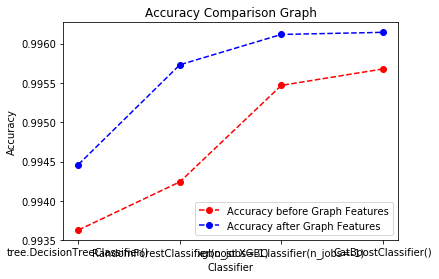

In [65]:
x1 = list(avg_accuracy_orig.keys())
y1 = list(avg_accuracy_orig.values())
plt.plot(x1, y1,  'ro', linestyle='dashed')

x2 = list(avg_accuracy_features.keys())
y2 = list(avg_accuracy_features.values())
plt.plot(x2, y2,  'bo', linestyle='dashed')


plt.savefig("out_f1.png")
plt.legend(['Accuracy before Graph Features', 'Accuracy after Graph Features'])
plt.title('Accuracy Comparison Graph')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.savefig
plt.show()